In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from full_utils import *
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from photutils.detection import find_peaks
from scipy.optimize import curve_fit
import glob
import pylab as pl

plt.rc('font', family='serif')
plt.rcParams["mathtext.fontset"] = 'cm'

In [3]:
d = 16.8

xpetal = np.array([]); ypetal = np.array([]);

for i in range(7):
    xpetal = np.concatenate( (xpetal, d + i*d/2. + np.arange(7-i)*d) )
    ypetal = np.concatenate( (ypetal, np.full(7-i, i*d*np.sqrt(3.)/2.)) )

xhole = np.array([])
yhole = np.array([])

for i in range(6):
    theta = i*np.pi/3.
    
    xhole = np.concatenate((xhole, np.cos(theta)*xpetal-np.sin(theta)*ypetal))
    yhole = np.concatenate((yhole, np.sin(theta)*xpetal+np.cos(theta)*ypetal))

fid_flag = np.zeros(xhole.size, dtype=np.int32)
for i in range(xhole.size):
    if i%28==6 or i%28==9 or i%28==23:
        fid_flag[i] = 1

fid_flag[34] = 0
fid_flag[40] = 1

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#!!! Modify Fiber Location!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!  
fid_flag[9] = 0
fid_flag[28*3+9] = 0

fid_flag[8] = 1
fid_flag[28*3+8] = 1

fid_flag = fid_flag.astype(bool)

In [4]:
x, y = xhole[fid_flag], yhole[fid_flag]

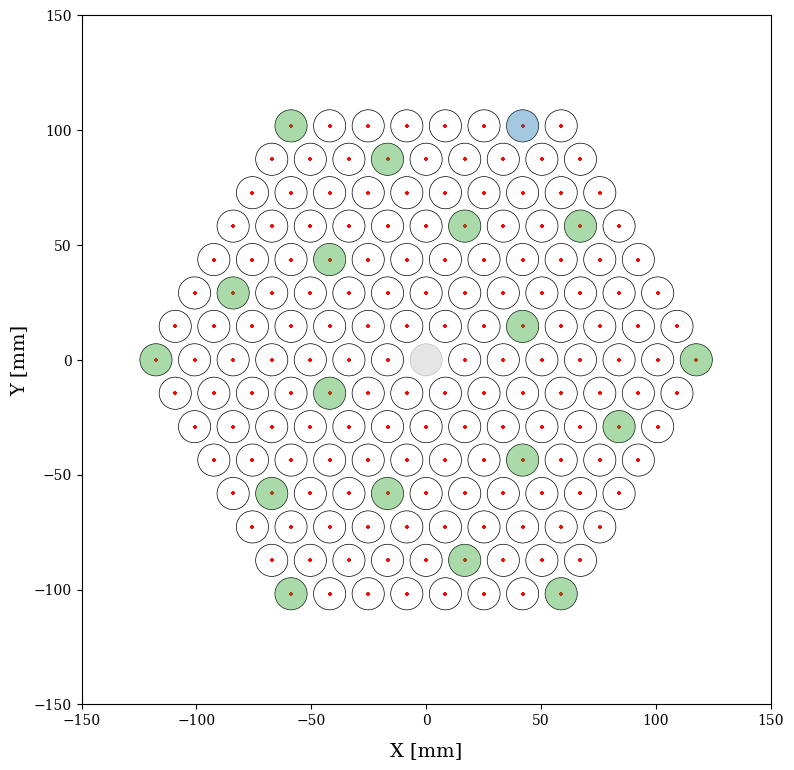

In [5]:
fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(xhole, yhole, marker='+', c='r', s=8)

for i in range(xhole.size):
    fc = 'none'
    if fid_flag[i]: fc = 'tab:green'
    if i > 167: fc = 'tab:orange'
    if i==40: fc ='tab:blue'
    c1 = plt.Circle((xhole[i], yhole[i]), 7, ec='k', fc='none', lw=0.5)
    ax.add_artist(c1)
    c1 = plt.Circle((xhole[i], yhole[i]), 7, ec='none', fc=fc, alpha=0.4)
    ax.add_artist(c1)

c1 = plt.Circle((0,0), 7, ec='k', fc='gray', lw=0.5, alpha=0.2)
ax.add_artist(c1)

ax.set_xlim(-150., 150.); ax.set_ylim(-150., 150.)
ax.set_aspect('equal')

ax.set_xlabel('X [mm]', fontsize=14, labelpad=10)
ax.set_ylabel('Y [mm]', fontsize=14)

plt.tight_layout()

In [6]:
im = fits.getdata('./FocusAdjust_Dark_108890_251224_0.fits')[::-1,:]

print(im.shape)

(8842, 11760)


In [7]:
npeaks = 18
threshold = 1e3
box_size = 40

peak_table_raw = find_peaks(im, threshold=threshold, box_size=box_size)#, npeaks=npeaks)
peak_table = dedupe_peaks_kdtree(peak_table_raw, min_dist=40)
xf, yf = peak_table['x_peak'].data, peak_table['y_peak'].data

print(npeaks, xf.size)

18 18


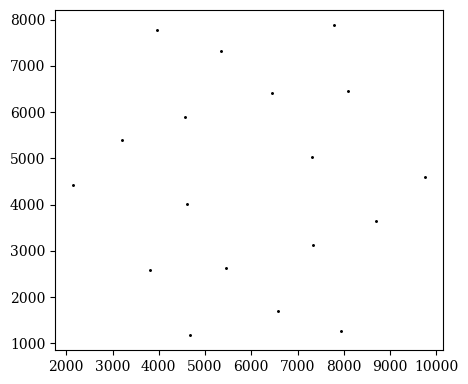

In [8]:
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(xf, yf, c='k', marker='.', s=5)

ax.set_aspect('equal')

In [9]:
nwindow = 40
xobs = np.zeros(xf.size); yobs = np.copy(xobs)

im_obs = np.zeros((xf.size, 2*nwindow, 2*nwindow))
im_peak = np.zeros(xf.size)

for ifiber in range(xf.size):
    ipredict = np.argmin( np.abs(xccd_global[xf[ifiber]]-xccd_global) )
    jpredict = np.argmin( np.abs(yccd_global[yf[ifiber]]-yccd_global) )

    im_crop = im[jpredict-nwindow:jpredict+nwindow, ipredict-nwindow:ipredict+nwindow]

    im_obs[ifiber] = im_crop

    im_peak[ifiber] = im_crop.max()

    x_crop = xccd_global[ipredict-nwindow:ipredict+nwindow]
    y_crop = yccd_global[jpredict-nwindow:jpredict+nwindow]

    xobs[ifiber], yobs[ifiber] = com(im_crop, x_crop, y_crop)

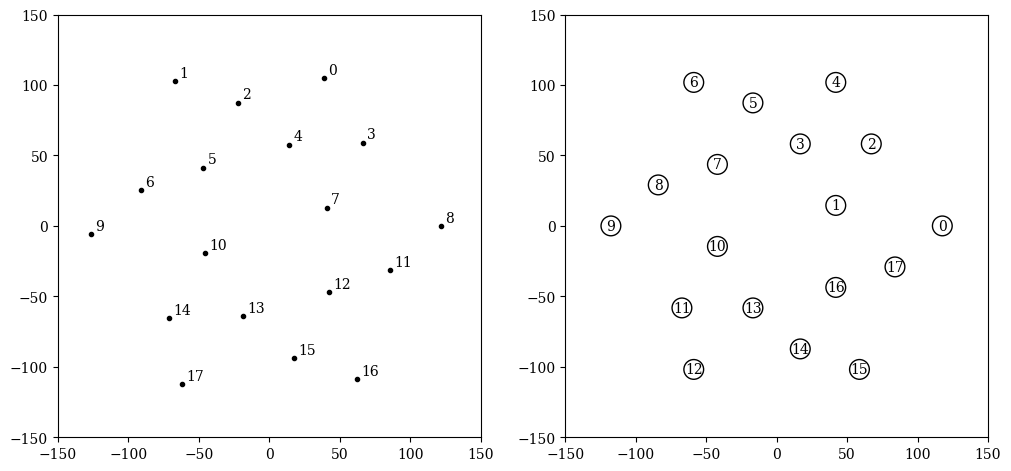

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12,8))

xobs_temp, yobs_temp = transform(xobs, yobs, camera2focal_coeff)

for i in range(xobs.size):
    ax[0].scatter(xobs_temp[i], yobs_temp[i], c='k', marker='.')
    ax[0].text(xobs_temp[i]+3, yobs_temp[i]+3, str(i))

#ax[0].set_xlim(xccd_global.min(), xccd_global.max())
#ax[0].set_ylim(yccd_global.min(), yccd_global.max())
#ax[0].set_xlim(-12., 12.)
#ax[0].set_ylim(-10., 10.)


for i in range(x.size):
    c1 = plt.Circle((x[i], y[i]), 7, fc='none', ec='k')
    ax[1].add_artist(c1)
    ax[1].text(x[i], y[i], str(i), ha='center', va='center')


for i in range(2):
    ax[i].set_xlim(-150, 150)
    ax[i].set_ylim(-150, 150)
    ax[i].set_aspect('equal')

19006.0
2386.0
10298.0
9803.0
33820.0
23370.0
1512.0
65534.0
24184.0
10675.0
14548.0
1868.0
42507.0
38479.0
11753.0
42198.0
20882.0
34510.0


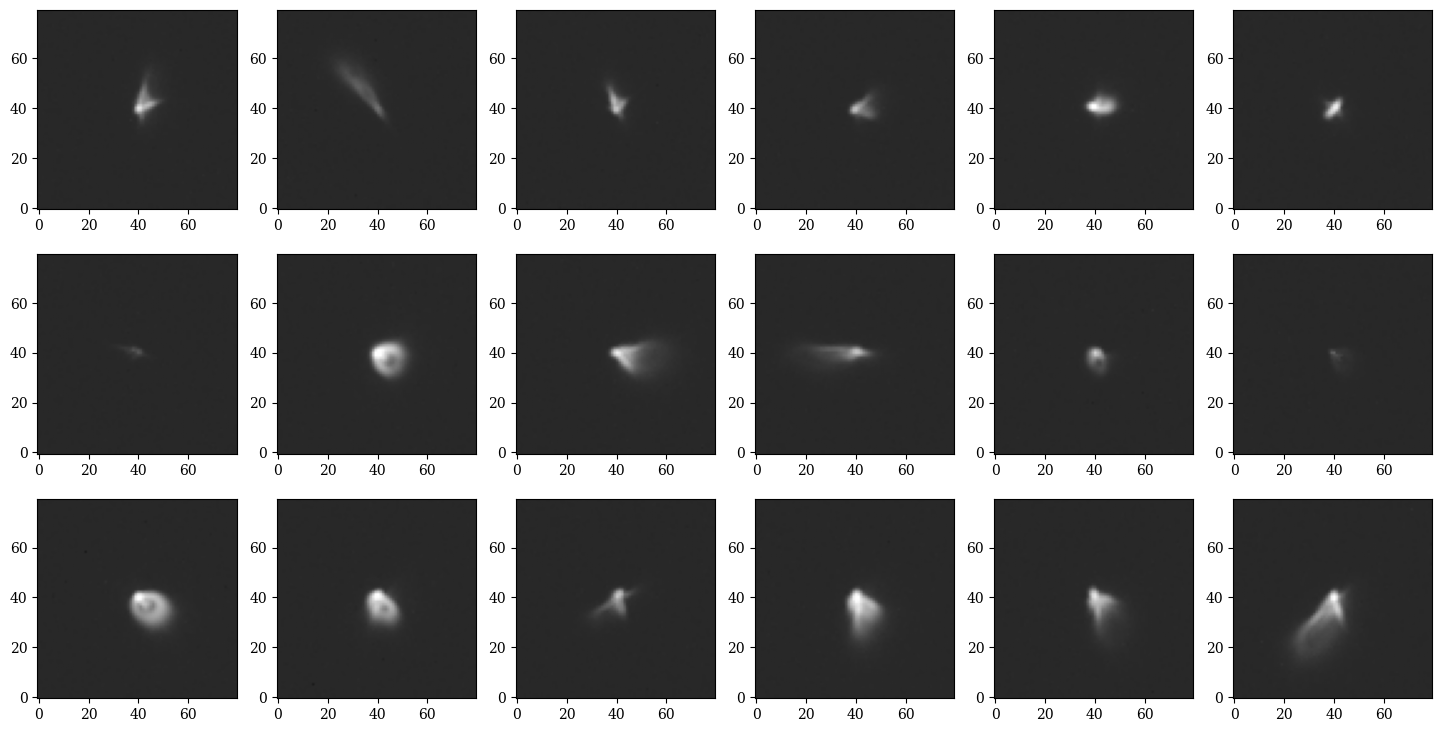

In [11]:
fig, ax = plt.subplots(3, 6, figsize=(18, 9))

nax = ax.flatten()

for i in range(18):
    nax[i].imshow(np.log10(im_obs[i]), origin='lower', cmap='gray', vmin=2.5, vmax=4.5)
    print(im_obs[i].max())

In [12]:
imatch, theta_guess, (xoff_guess, yoff_guess) = Match_Fiber(x, y, xobs, yobs, nbuffer=20)
xobs_match = xobs[imatch]; yobs_match = yobs[imatch]

print(theta_guess)
print(xoff_guess, yoff_guess)

6.256968956801924
2.5 3.0


In [13]:
xobs_temp, yobs_temp = transform(xobs, yobs, camera2focal_coeff)

In [14]:
nhunt = 720
theta_grid = np.linspace(0., 2.*np.pi, nhunt)
dd_sum = np.zeros(nhunt)
for ihunt, theta_temp in enumerate(theta_grid):
    xobs_rot = np.cos(theta_temp)*xobs_temp - np.sin(theta_temp)*yobs_temp
    yobs_rot = np.sin(theta_temp)*xobs_temp + np.cos(theta_temp)*yobs_temp
    obs_flag = np.concatenate( (np.full(xobs_temp.size, 0), np.full(xobs_temp.size, 1)) )
    pos_tot = np.concatenate( (np.vstack((x, y)).T
                                , np.vstack((xobs_rot, yobs_rot)).T) )

    tree = cKDTree(pos_tot)
    dd, ii = tree.query(pos_tot, k=8)

    for ipeak in range(xobs.size):
        dd_sum[ihunt] += dd[ipeak][obs_flag[ii[ipeak]] == 1].min()

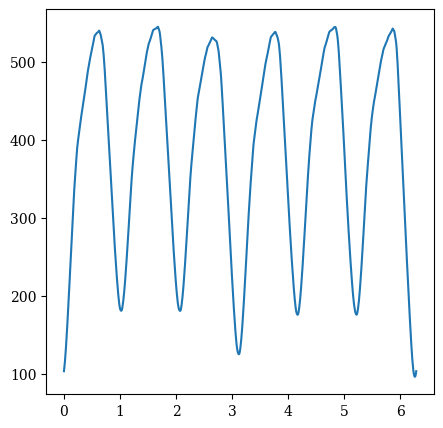

In [15]:
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(theta_grid, dd_sum)

In [16]:
add = 0.

xobs_rot = np.cos(theta_guess+add)*xobs_temp - np.sin(theta_guess+add)*yobs_temp
yobs_rot = np.sin(theta_guess+add)*xobs_temp + np.cos(theta_guess+add)*yobs_temp

In [17]:
ngrid = 80
offset_grid = np.linspace(-10., 10., ngrid)
dsum_temp = np.zeros((ngrid, ngrid))
for i in range(ngrid):
    for j in range(ngrid):
        tree = cKDTree(np.c_[xobs_rot+offset_grid[i], yobs_rot+offset_grid[j]])
        d, _ = tree.query(np.c_[x, y], k=1)

        dsum_temp[i,j] = d.sum()

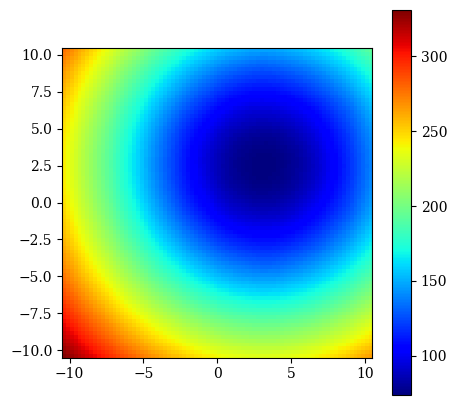

In [18]:
fig, ax = plt.subplots(figsize=(5,5))

im = ax.imshow(dsum_temp, origin='lower', cmap='jet', extent = [-10.-0.5, 10.+0.5, -10.-0.5, 10.+0.5])
fig.colorbar(im)

In [19]:
imin, jmin = np.unravel_index(dsum_temp.argmin(), dsum_temp.shape)

xobs_rot += offset_grid[imin]
yobs_rot += offset_grid[jmin]

print(offset_grid[imin], offset_grid[jmin])

2.405063291139241 2.9113924050632924


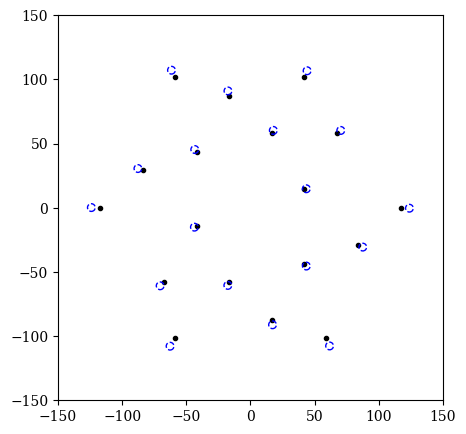

In [20]:
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(x, y, c='k', marker='.')

for i in range(xobs_rot.size):
    #c1 = plt.Circle((xobs_temp[i], yobs_temp[i]), 3, fc='none', ec='r', ls='--')
    #ax.add_artist(c1)
    
    c1 = plt.Circle((xobs_rot[i], yobs_rot[i]), 3, fc='none', ec='b', ls='--')
    ax.add_artist(c1)

ax.set_xlim(-150., 150.)
ax.set_ylim(-150., 150.)
ax.set_aspect('equal')

In [21]:
xfit = np.concatenate((xobs_match, xobs_match))
yfit = np.concatenate((yobs_match, yobs_match))
ccd_fit = np.concatenate((x, y))


inv_popt_obs, _ = curve_fit(transform_polynomial, (xfit, yfit), ccd_fit
                       , maxfev=20000
                       , p0=[
                           camera2focal_coeff[0],
                           theta_guess,
                           -xoff_guess, -yoff_guess,
                           *camera2focal_coeff[4:]
                            ]
                       )
"""
inv_popt_obs, _ = curve_fit(distrad_SingleTelescope, (xfit, yfit), ccd_fit
                       , maxfev=20000
                       , p0=[
                           camera2focal_coeff[0],
                           theta_guess,
                           -xoff_guess, -yoff_guess,
                           *camera2focal_coeff[4:7]
                            ]
                       )
"""
print(inv_popt_obs)

[-8.18345749e+00  6.25950467e+00 -2.30393528e+00 -2.90710897e+00
  3.02261380e-06 -6.79466330e-10  6.25313001e-14 -2.04446764e-18
  1.05431672e-09 -1.74349097e-09  7.86454732e-01 -5.96107073e-05
  4.69284185e-12 -2.58824314e-12  1.71541358e-09  5.54492748e-09]


In [22]:
xfocal_obs, yfocal_obs = transform(xobs_match, yobs_match, inv_popt_obs)

dx = xfocal_obs-x
dy = yfocal_obs-y

dr = np.sqrt(dx**2 + dy**2)

for i in range(xfocal_obs.size):
    
    print(i, xfocal_obs[i], yfocal_obs[i], x[i], y[i], dx[i]*1e3, dy[i]*1e3, dr[i]*1e3, im_peak[imatch][i])

0 117.73691146560643 0.12274499997279342 117.60000000000001 0.0 136.91146560641698 122.74499997279342 183.87790632052065 24184.0
1 41.91021261329183 14.47736522872155 42.0 14.549226783578568 -89.7873867081671 -71.8615548570174 115.00372984538399 65534.0
2 67.31036740113464 58.02918633723792 67.2 58.19690713431427 110.3674011346385 -167.72079707635612 200.7765648803227 9803.0
3 16.999779566919393 58.21103386264123 16.80000000000001 58.19690713431428 199.77956691938203 14.126728326949944 200.27840575488733 33820.0
4 41.89100200332507 101.97358544736505 42.000000000000014 101.84458748504998 -108.99799667494392 128.99796231506855 168.88172654432134 19006.0
5 -17.00988381766603 87.20820295764132 -16.799999999999983 87.29536070147142 -209.88381766604647 -87.15774383010455 227.26127964884023 10298.0
6 -58.7079599765262 101.80614126828848 -58.799999999999976 101.84458748505 92.04002347377838 -38.44621676151405 99.74706764776096 2386.0
7 -41.905498309715576 43.689087142395024 -41.99999999999998

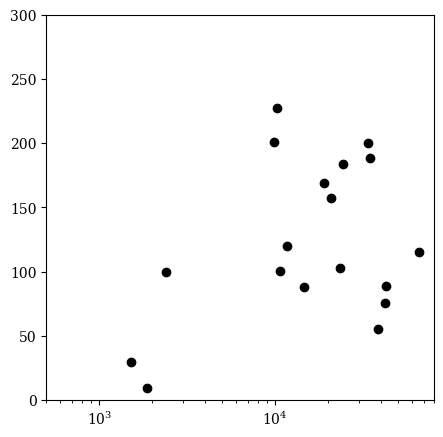

In [23]:
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(im_peak[imatch], dr*1e3, c='k')

ax.set_xlim(5e2, 8e4)
ax.set_ylim(0., 3e2)
ax.set_xscale('log')

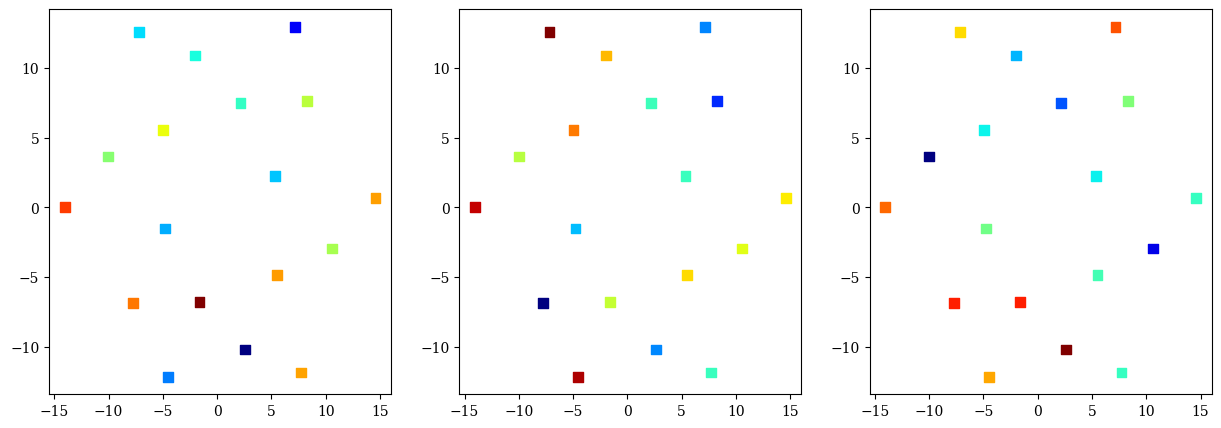

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

ax[0].scatter(xobs_match, yobs_match, c=dx, cmap='jet', marker='s', s=50)
ax[1].scatter(xobs_match, yobs_match, c=dy, cmap='jet', marker='s', s=50)
ax[2].scatter(xobs_match, yobs_match, c=np.sqrt(dx**2 + dy**2), cmap='jet', marker='s', s=50)

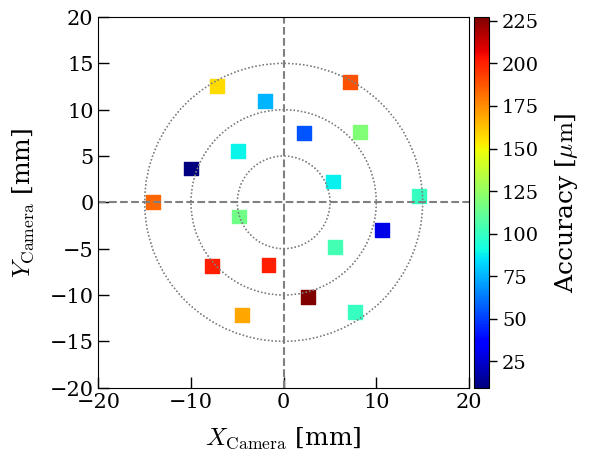

In [25]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(6,6))

sc = ax.scatter(xobs_match, yobs_match,
                c=np.sqrt(dx**2 + dy**2)*1e3,
                cmap='jet', marker='s', s=100)

ax.set_xlim(-20., 20.)
ax.set_ylim(-20., 20.)
ax.set_aspect('equal')

for i in range(3):
    c1 = plt.Circle((0,0), 5*(i+1), fc='none', ec='gray', lw=1, ls=':')
    ax.add_artist(c1)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.05)  # size/pad는 취향대로
cbar = fig.colorbar(sc, cax=cax)

cbar.ax.tick_params(length=6, width=1, labelsize=14)
cbar.set_label(r'Accuracy [$\mu\mathrm{m}$]', fontsize=18, labelpad=10)


ax.axhline(0., 0., 1., c='gray', ls='--')
ax.axvline(0., 0., 1., c='gray', ls='--')

ax.tick_params(direction='in', labelsize=15, length=8, width=1)

ax.set_xlabel(r'$X_{\mathrm{Camera}}$ [mm]', fontsize=18, labelpad=10)
ax.set_ylabel(r'$Y_{\mathrm{Camera}}$ [mm]', fontsize=18, labelpad=10)

for i in range(3):
    c1 = plt.Circle((0,0), 5*(i+1), fc='none', ec='gray', lw=1, ls=':')
    ax.add_artist(c1)

plt.tight_layout()

#plt.savefig('../figures/251219/accuracy.png', dpi=200)

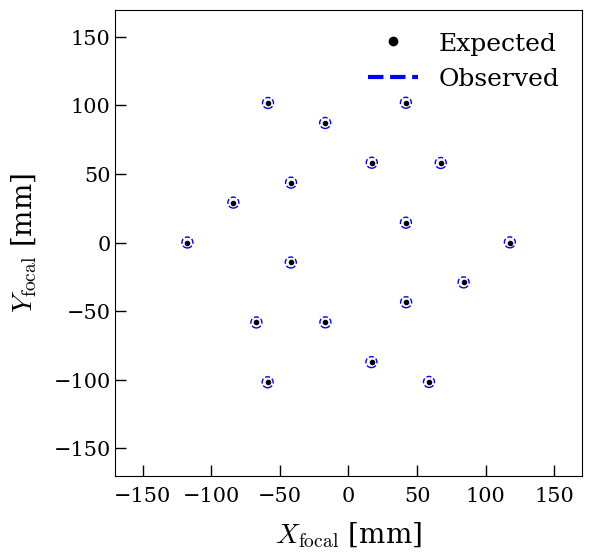

In [26]:
fig, ax = plt.subplots(figsize=(6,6))

for i in range(xobs_match.size):
    c1 = plt.Circle((xfocal_obs[i], yfocal_obs[i]), 4., fc='none', ec='b', ls='--')
    ax.add_artist(c1)

    #ax.text(xfocal_obs[i]+2, yfocal_obs[i]+2, str(i+1), color='b', fontsize=15)

ax.scatter(x, y, c='k', marker='.')


from matplotlib.lines import Line2D

custom_lines = [Line2D([0], [0], color='k', ls='none', marker='o', lw=3),
                Line2D([0], [0], color='b', ls='--', lw=3)]

ax.legend(custom_lines, ['Expected', 'Observed'], frameon=False, fontsize=18, loc='upper right')

ax.set_xlim(-170, 170)
ax.set_ylim(-170, 170)
ax.set_aspect('equal')

ax.tick_params(axis='x', direction='in', labelsize=15, length=8, width=1, pad=8)
ax.tick_params(axis='y', direction='in', labelsize=15, length=8, width=1)

ax.set_xlabel(r'$X_{\mathrm{focal}}$ [mm]', fontsize=20, labelpad=10)
ax.set_ylabel(r'$Y_{\mathrm{focal}}$ [mm]', fontsize=20, labelpad=10)

plt.tight_layout()
#plt.savefig('../figures/251219/loc.png', dpi=200)

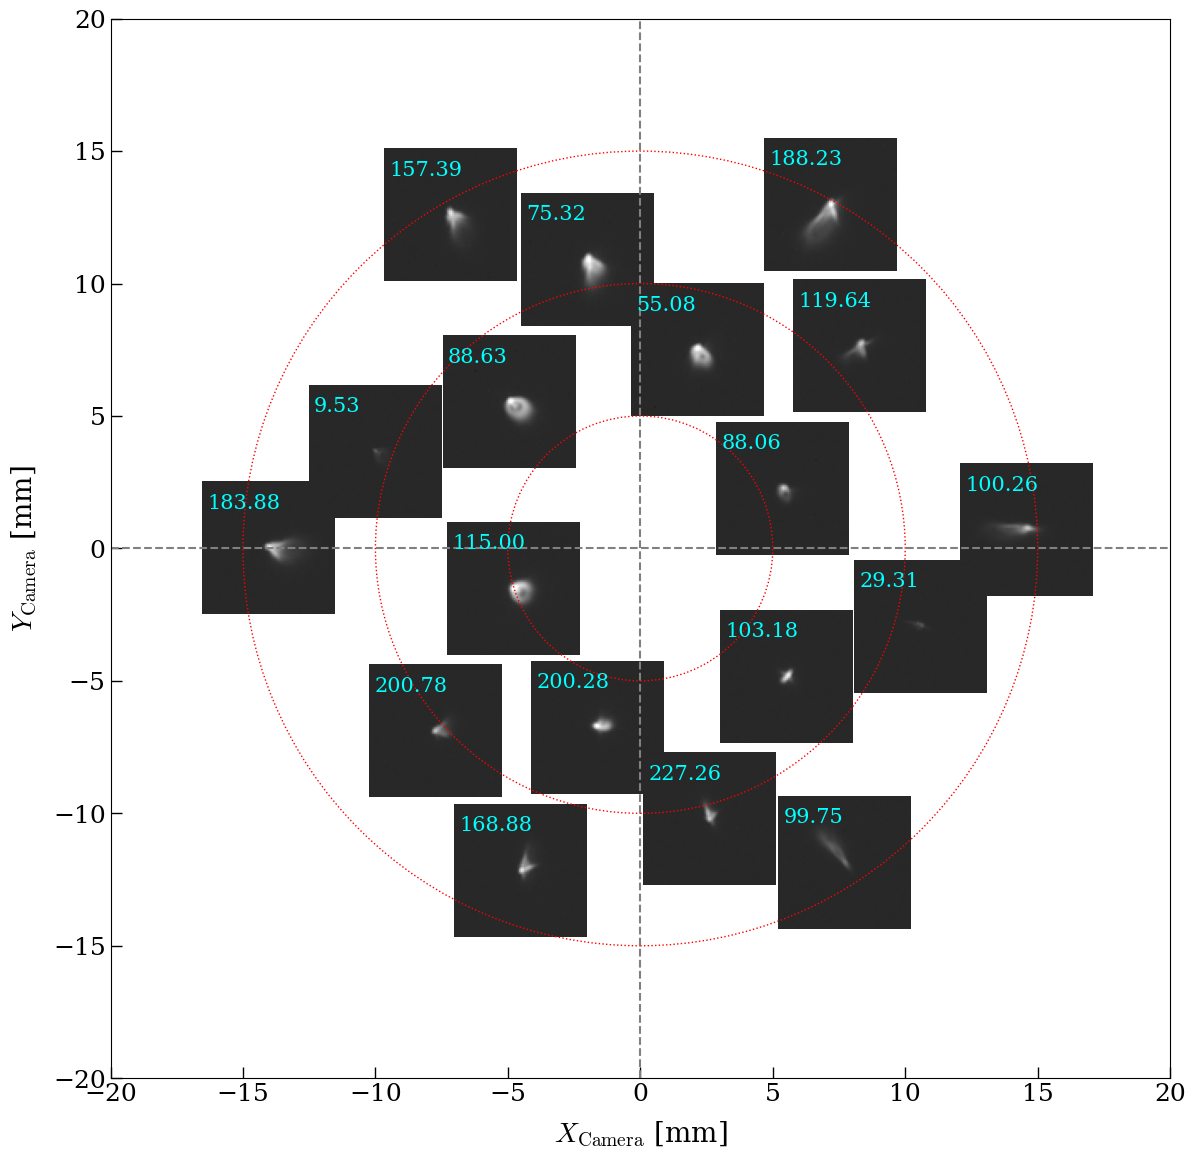

In [27]:
fig, ax = plt.subplots(figsize=(12,12))

width = 2.5

for i in range(18):

    extent = [xobs[imatch][i]-width, xobs[imatch][i]+width, yobs[imatch][i]-width, yobs[imatch][i]+width]

    ax.imshow(np.log10(im_obs[imatch][i]), origin='lower', cmap='gray', vmin=2.5, vmax=4.5, extent=extent)

    ax.text(xobs[imatch][i]-width+0.2, yobs[imatch][i]+width-1, f'{(dr[i]*1e3):.2f}', c='cyan', fontsize=15)

ax.axhline(0., 0., 1., c='gray', ls='--')
ax.axvline(0., 0., 1., c='gray', ls='--')

ax.set_xlim(-20., 20.)
ax.set_ylim(-20., 20.)

ax.tick_params(direction='in', labelsize=18, length=8, width=1)

ax.set_xlabel(r'$X_{\mathrm{Camera}}$ [mm]', fontsize=20, labelpad=10)
ax.set_ylabel(r'$Y_{\mathrm{Camera}}$ [mm]', fontsize=20, labelpad=10)

ax.set_aspect('equal')

for i in range(3):
    c1 = plt.Circle((0,0), 5*(i+1), fc='none', ec='r', lw=1, ls=':')
    ax.add_artist(c1)


plt.tight_layout()
#plt.savefig('../figures/251219/fid_image.png', dpi=200)

In [31]:
xiter, yiter = np.copy(xfocal_obs), np.copy(yfocal_obs)
print(xiter, yiter)
for ii in range(1):
    ccd_fit = np.concatenate((xiter, yiter))

    inv_popt_obs, _ = curve_fit(transform_polynomial, (xfit, yfit), ccd_fit
                        , maxfev=20000
                        , p0=[
                            camera2focal_coeff[0],
                            theta_guess,
                            -xoff_guess, -yoff_guess,
                            *camera2focal_coeff[4:]
                                ]
                        )
    
    xiter_new, yiter_new = transform(xobs_match, yobs_match, inv_popt_obs)

    dx = xiter_new - xiter
    dy = yiter_new - yiter

    print(dx, dy)

    xiter = xiter_new
    yiter = yiter_new

[-117.75878895  -41.91666094  -67.29610684  -17.05088277  -41.93475165
   16.99198547   58.66232559   41.91408549   83.85811794  117.50972863
   42.04268168   67.27724772   58.97247197   16.83569901  -16.69471291
  -58.70483306  -42.02472434  -83.88288208] [ 9.65810361e-02  1.45007951e+01  5.80680192e+01  5.82351826e+01
  1.01967394e+02  8.73141454e+01  1.01817632e+02  4.37353889e+01
  2.90514266e+01 -1.11422529e-01 -1.45484312e+01 -5.84310665e+01
 -1.01954174e+02 -5.82320443e+01 -8.72471283e+01 -1.01658221e+02
 -4.35450146e+01 -2.90590624e+01]
[ 1.42108547e-14  1.42108547e-14  0.00000000e+00  3.55271368e-15
  0.00000000e+00 -3.55271368e-15  0.00000000e+00  0.00000000e+00
 -1.42108547e-14  0.00000000e+00  0.00000000e+00 -1.42108547e-14
  0.00000000e+00 -7.10542736e-15  1.06581410e-14  7.10542736e-15
  7.10542736e-15  1.42108547e-14] [-1.77635684e-15 -5.32907052e-15  0.00000000e+00  0.00000000e+00
  1.42108547e-14  0.00000000e+00  1.42108547e-14 -7.10542736e-15
 -7.10542736e-15 -1.33226

In [29]:
print(xiter_new, yiter_new)

[-117.75878895  -41.91666094  -67.29610684  -17.05088277  -41.93475165
   16.99198547   58.66232559   41.91408549   83.85811794  117.50972863
   42.04268168   67.27724772   58.97247197   16.83569901  -16.69471291
  -58.70483306  -42.02472434  -83.88288208] [ 9.65810361e-02  1.45007951e+01  5.80680192e+01  5.82351826e+01
  1.01967394e+02  8.73141454e+01  1.01817632e+02  4.37353889e+01
  2.90514266e+01 -1.11422529e-01 -1.45484312e+01 -5.84310665e+01
 -1.01954174e+02 -5.82320443e+01 -8.72471283e+01 -1.01658221e+02
 -4.35450146e+01 -2.90590624e+01]


In [204]:
npeaks = 18
threshold = 5e2
box_size = 40
nwindow = 40

x, y = -xhole[fid_flag], yhole[fid_flag]

nframe = 100
nfiber = 18

xobs = np.zeros((nframe, nfiber)); yobs = np.copy(xobs)

im_obs = np.zeros((nframe, nfiber, 2*nwindow, 2*nwindow))
im_peak = np.zeros((nframe, nfiber))

xfocal_obs = np.zeros_like(xobs); yfocal_obs = np.zeros_like(yobs)

sat_flag = np.zeros(nframe, dtype=bool)

for iframe in range(nframe):
    im = fits.getdata(f'/md/cruithne/MOS/SingleTelescope/data/251219/test{iframe}.fits')

    if im.max() >= 65534:
        sat_flag[iframe] = True

    peak_table_raw = find_peaks(im, threshold=threshold, box_size=box_size, npeaks=npeaks)
    peak_table = dedupe_peaks_kdtree(peak_table_raw, min_dist=40)
    xf, yf = peak_table['x_peak'].data, peak_table['y_peak'].data
    print(iframe, npeaks, xf.size)


    for ifiber in range(nfiber):
        ipredict = np.argmin( np.abs(xccd_global[xf[ifiber]]-xccd_global) )
        jpredict = np.argmin( np.abs(yccd_global[yf[ifiber]]-yccd_global) )

        im_crop = im[jpredict-nwindow:jpredict+nwindow, ipredict-nwindow:ipredict+nwindow]

        im_obs[iframe, ifiber] = im_crop

        im_peak[iframe, ifiber] = im_crop.max()

        x_crop = xccd_global[ipredict-nwindow:ipredict+nwindow]
        y_crop = yccd_global[jpredict-nwindow:jpredict+nwindow]

        xobs[iframe, ifiber], yobs[iframe, ifiber] = com(im_crop, x_crop, y_crop)

    imatch, theta_guess, (xoff_guess, yoff_guess) = Match_Fiber(x, y, xobs[iframe], yobs[iframe], nbuffer=20)
    xobs_match = xobs[iframe][imatch]; yobs_match = yobs[iframe][imatch]

    xobs_rot = np.cos(theta_guess+add)*xobs_temp - np.sin(theta_guess+add)*yobs_temp
    yobs_rot = np.sin(theta_guess+add)*xobs_temp + np.cos(theta_guess+add)*yobs_temp

    ngrid = 80
    offset_grid = np.linspace(-10., 10., ngrid)
    dsum_temp = np.zeros((ngrid, ngrid))
    for i in range(ngrid):
        for j in range(ngrid):
            tree = cKDTree(np.c_[xobs_rot+offset_grid[i], yobs_rot+offset_grid[j]])
            d, _ = tree.query(np.c_[x, y], k=1)

            dsum_temp[i,j] = d.sum()

    xobs_rot += offset_grid[imin]
    yobs_rot += offset_grid[jmin]

    xfit = np.concatenate((xobs_match, xobs_match))
    yfit = np.concatenate((yobs_match, yobs_match))
    ccd_fit = np.concatenate((x, y))

    
    inv_popt_obs, _ = curve_fit(transform_polynomial, (xfit, yfit), ccd_fit
                        , maxfev=20000
                        , p0=[
                            camera2focal_coeff[0],
                            theta_guess,
                            -xoff_guess, -yoff_guess,
                            *camera2focal_coeff[4:]
                                ]
                        )
    xfocal_obs[iframe], yfocal_obs[iframe] = transform(xobs_match, yobs_match, inv_popt_obs)
    """
    inv_popt_obs, _ = curve_fit(distrad_SingleTelescope, (xfit, yfit), ccd_fit
                        , maxfev=20000
                        , p0=[
                            camera2focal_coeff[0],
                            theta_guess,
                            -xoff_guess, -yoff_guess,
                            *camera2focal_coeff[4:7]
                                ]
                        )
    xfocal_obs[iframe], yfocal_obs[iframe] = transform_single(xobs_match, yobs_match, inv_popt_obs)
    """

0 18 18
1 18 18
2 18 18
3 18 18
4 18 18
5 18 18
6 18 18
7 18 18
8 18 18
9 18 18
10 18 18
11 18 18
12 18 18
13 18 18
14 18 18
15 18 18
16 18 18
17 18 18
18 18 18
19 18 18
20 18 18
21 18 18
22 18 18
23 18 18
24 18 18
25 18 18
26 18 18
27 18 18
28 18 18
29 18 18
30 18 18
31 18 18
32 18 18
33 18 18
34 18 18
35 18 18
36 18 18
37 18 18
38 18 18
39 18 18
40 18 18
41 18 18
42 18 18
43 18 18
44 18 18
45 18 18
46 18 18
47 18 18
48 18 18
49 18 18
50 18 18
51 18 18
52 18 18
53 18 18
54 18 18
55 18 18
56 18 18
57 18 18
58 18 18
59 18 18
60 18 18
61 18 18
62 18 18
63 18 18
64 18 18
65 18 18
66 18 18
67 18 18
68 18 18
69 18 18
70 18 18
71 18 18
72 18 18
73 18 18
74 18 18
75 18 18
76 18 18
77 18 18
78 18 18
79 18 18
80 18 18
81 18 18
82 18 18
83 18 18
84 18 18
85 18 18
86 18 18
87 18 18
88 18 18
89 18 18
90 18 18
91 18 18
92 18 18
93 18 18
94 18 18
95 18 18
96 18 18
97 18 18
98 18 18
99 18 18


In [205]:
px, py = (xfocal_obs - np.median(xfocal_obs, axis=0)), (yfocal_obs - np.median(yfocal_obs, axis=0))
pr = np.sqrt(px**2 + py**2)

In [212]:
sx = np.std(xfocal_obs, axis=0)
sy = np.std(yfocal_obs, axis=0)

sr = np.sqrt(sx**2 + sy**2)

print(sx*1e3)
print(sy*1e3)
print(sr*1e3)

[ 8.22029641 10.15818647  7.28918747 10.6645149   3.93962187  6.11907219
  8.75056645  4.94099412 14.27528731  8.82159331 15.28010109  5.34338801
  7.83666209  8.12596769  8.65655182  4.54342423  8.77603965 12.69185635]
[ 8.73797136  8.19700135  7.4204991  15.68316798  9.6489915  12.45243564
  5.61057359  9.52678224  9.22874726  6.88771165  5.07234612  8.2098787
  4.47359463 11.76350459  6.96704984  5.2703942   5.04572664  8.10657264]
[11.99689195 13.05295305 10.40173355 18.96559084 10.42226738 13.87466028
 10.39475586 10.73186856 16.99863535 11.19200966 16.10000573  9.79560635
  9.02365345 14.29725117 11.11196081  6.95843077 10.12315312 15.05987176]


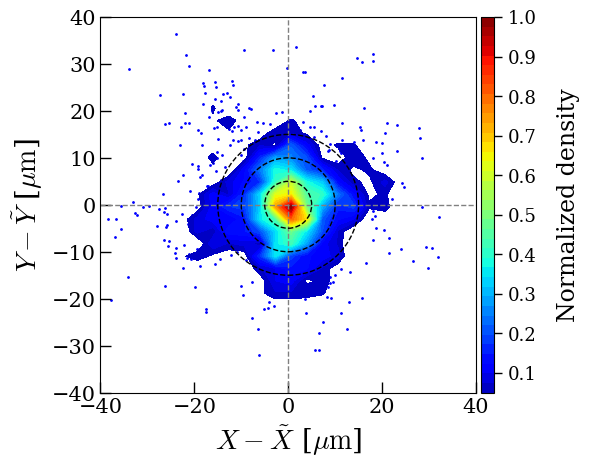

In [149]:
fig, ax = plt.subplots(figsize=(6,6))

points, cs = scatter_contour(
    px.flatten()*1e3, py.flatten()*1e3, ax=ax,
    normalize='max',
    threshold=0.05,                 # 1% 이상부터 시작
    levels=40,
    histogram2d_args={'bins': 30},
    contour_args={'cmap' : 'jet', 'vmin' : 0., 'vmax' : 1.},
    plot_args={'c' : 'b', 'marker' : '.', 'ms' : 2}
)


from mpl_toolkits.axes_grid1 import make_axes_locatable

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3.5%", pad=0.05)
cb = fig.colorbar(cs, cax=cax)
cb.set_label('Normalized density', labelpad=15, fontsize=17)
cb.set_ticks(np.arange(1,11)*0.1)
cb.ax.tick_params(length=6, width=1, labelsize=13)

ax.set_xlim(-40., 40.)
ax.set_ylim(-40., 40.)

ax.axhline(0., 0., 1., c='gray', ls='--', lw=1)
ax.axvline(0., 0., 1., c='gray', ls='--', lw=1)

ax.set_aspect('equal')

for i in range(3):
    c1 = plt.Circle((0,0), 5*(i+1), fc='none', ec='k', lw=1, zorder=3, ls='--')
    ax.add_artist(c1)

ax.tick_params(direction='in', length=8, width=1, labelsize=15)
ax.set_xlabel(r'$X-\tilde{X}$ [$\mu\mathrm{m}$]', fontsize=20, labelpad=5)
ax.set_ylabel(r'$Y-\tilde{Y}$ [$\mu\mathrm{m}$]', fontsize=20, labelpad=5)

plt.tight_layout()

#plt.savefig('../figures/251219/precision.png', dpi=200)

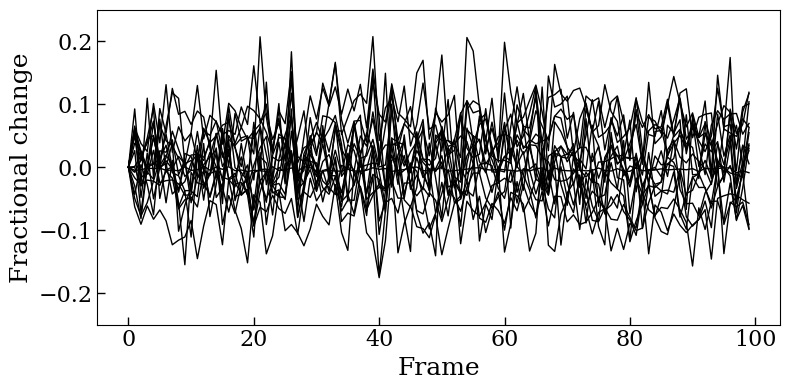

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))

for i in range(nfiber):
    ax.plot(np.arange(100), im_peak[:,i]/im_peak[0,i]-1., c='k', lw=1)

    #print(im_peak[:,i])

ax.set_ylim(-0.25, 0.25)


ax.set_xlabel('Frame', fontsize=18)
ax.set_ylabel('Fractional change', fontsize=18)

ax.tick_params(direction='in', length=6, width=1, labelsize=16)

plt.tight_layout()
#plt.savefig('../figures/251219/peak_pixel.png', dpi=200)

In [150]:
dx, dy = (xfocal_obs - x), (yfocal_obs - y)
dr = np.sqrt(dx**2 + dy**2)

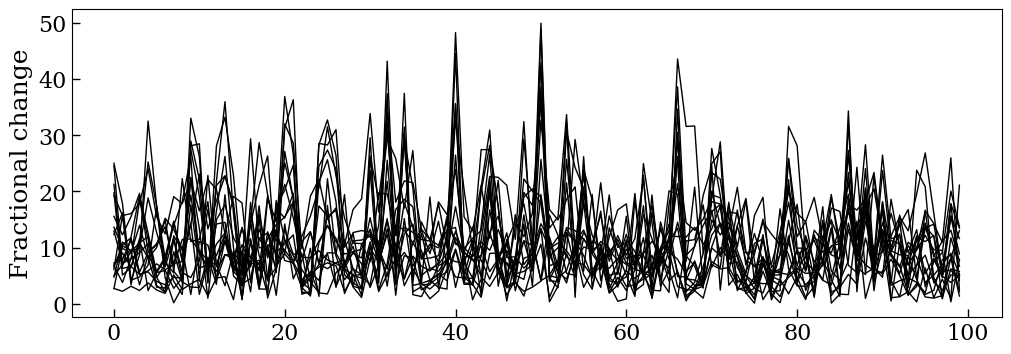

In [164]:
fig, ax = plt.subplots(figsize=(12,4))

for i in range(nfiber):
    ax.plot(np.arange(100), pr[:,i]*1e3, c='k', lw=1)

ax.set_ylabel('Fractional change', fontsize=18)
ax.tick_params(direction='in', length=6, width=1, labelsize=16)

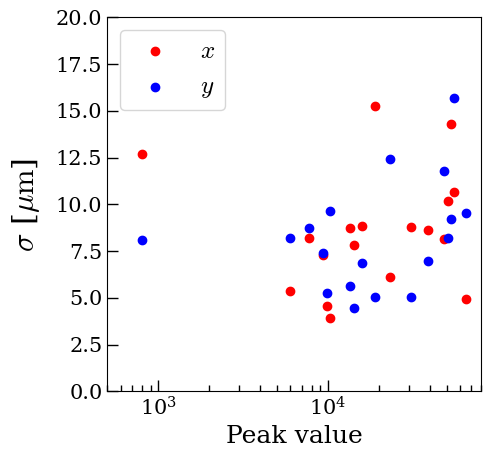

In [230]:
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(np.mean(im_peak[:,imatch], axis=0), sx*1e3, c='r', marker='o', label=r'$x$')
ax.scatter(np.mean(im_peak[:,imatch], axis=0), sy*1e3, c='b', marker='o', label=r'$y$')

ax.set_xlim(5e2, 8e4)
ax.set_ylim(0., 20)
ax.set_xscale('log')

ax.tick_params(which='major', direction='in', length=8, width=1, labelsize=15)
ax.tick_params(which='minor', direction='in', length=4, width=1, labelsize=15)

ax.set_xlabel(r'Peak value', fontsize=18)
ax.set_ylabel(r'$\sigma$ [$\mu\mathrm{m}$]', fontsize=22, labelpad=10)

ax.legend(fontsize=18, frameon=True)

ax.set_box_aspect(1)

plt.tight_layout()

plt.savefig('../figures/251219/precision_peakval.png', dpi=200)

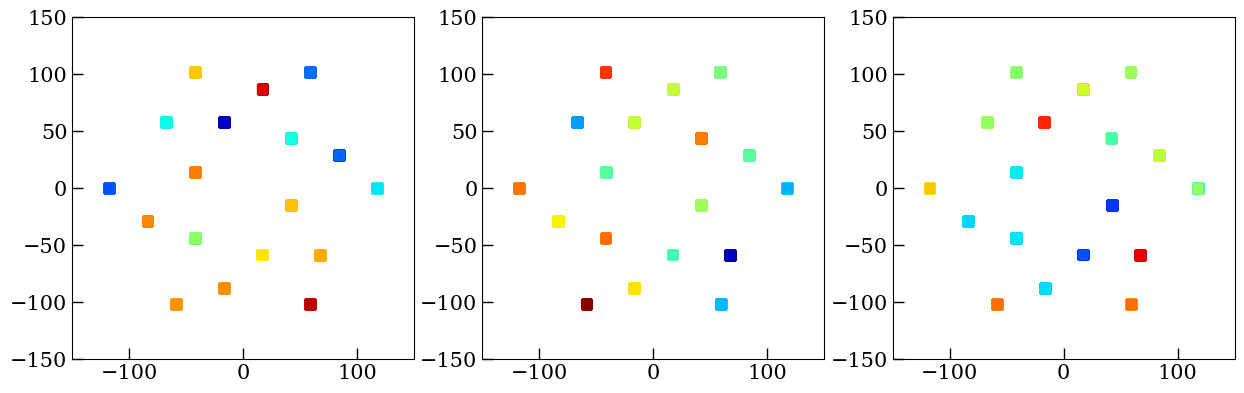

In [168]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

ax[0].scatter(xfocal_obs, yfocal_obs, c=dx, cmap='jet', marker='s', s=50)
ax[1].scatter(xfocal_obs, yfocal_obs, c=dy, cmap='jet', marker='s', s=50)
ax[2].scatter(xfocal_obs, yfocal_obs, c=dr, cmap='jet', marker='s', s=50)

for i in range(3):
    ax[i].tick_params(direction='in', length=8, width=1, labelsize=15)

    ax[i].set_xlim(-150., 150.)
    ax[i].set_ylim(-150., 150.)

    ax[i].set_aspect('equal')

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

ax[0].scatter(xfocal_obs, yfocal_obs, c=dx, cmap='jet', marker='s', s=50)
ax[1].scatter(xfocal_obs, yfocal_obs, c=dy, cmap='jet', marker='s', s=50)
ax[2].scatter(xfocal_obs, yfocal_obs, c=dr, cmap='jet', marker='s', s=50)

for i in range(3):
    ax[i].tick_params(direction='in', length=8, width=1, labelsize=15)

    ax[i].set_xlim(-150., 150.)
    ax[i].set_ylim(-150., 150.)

    ax[i].set_aspect('equal')